<a href="https://colab.research.google.com/github/Kaveriharamagatti/NVIDIA_async_detection/blob/main/Methodology_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

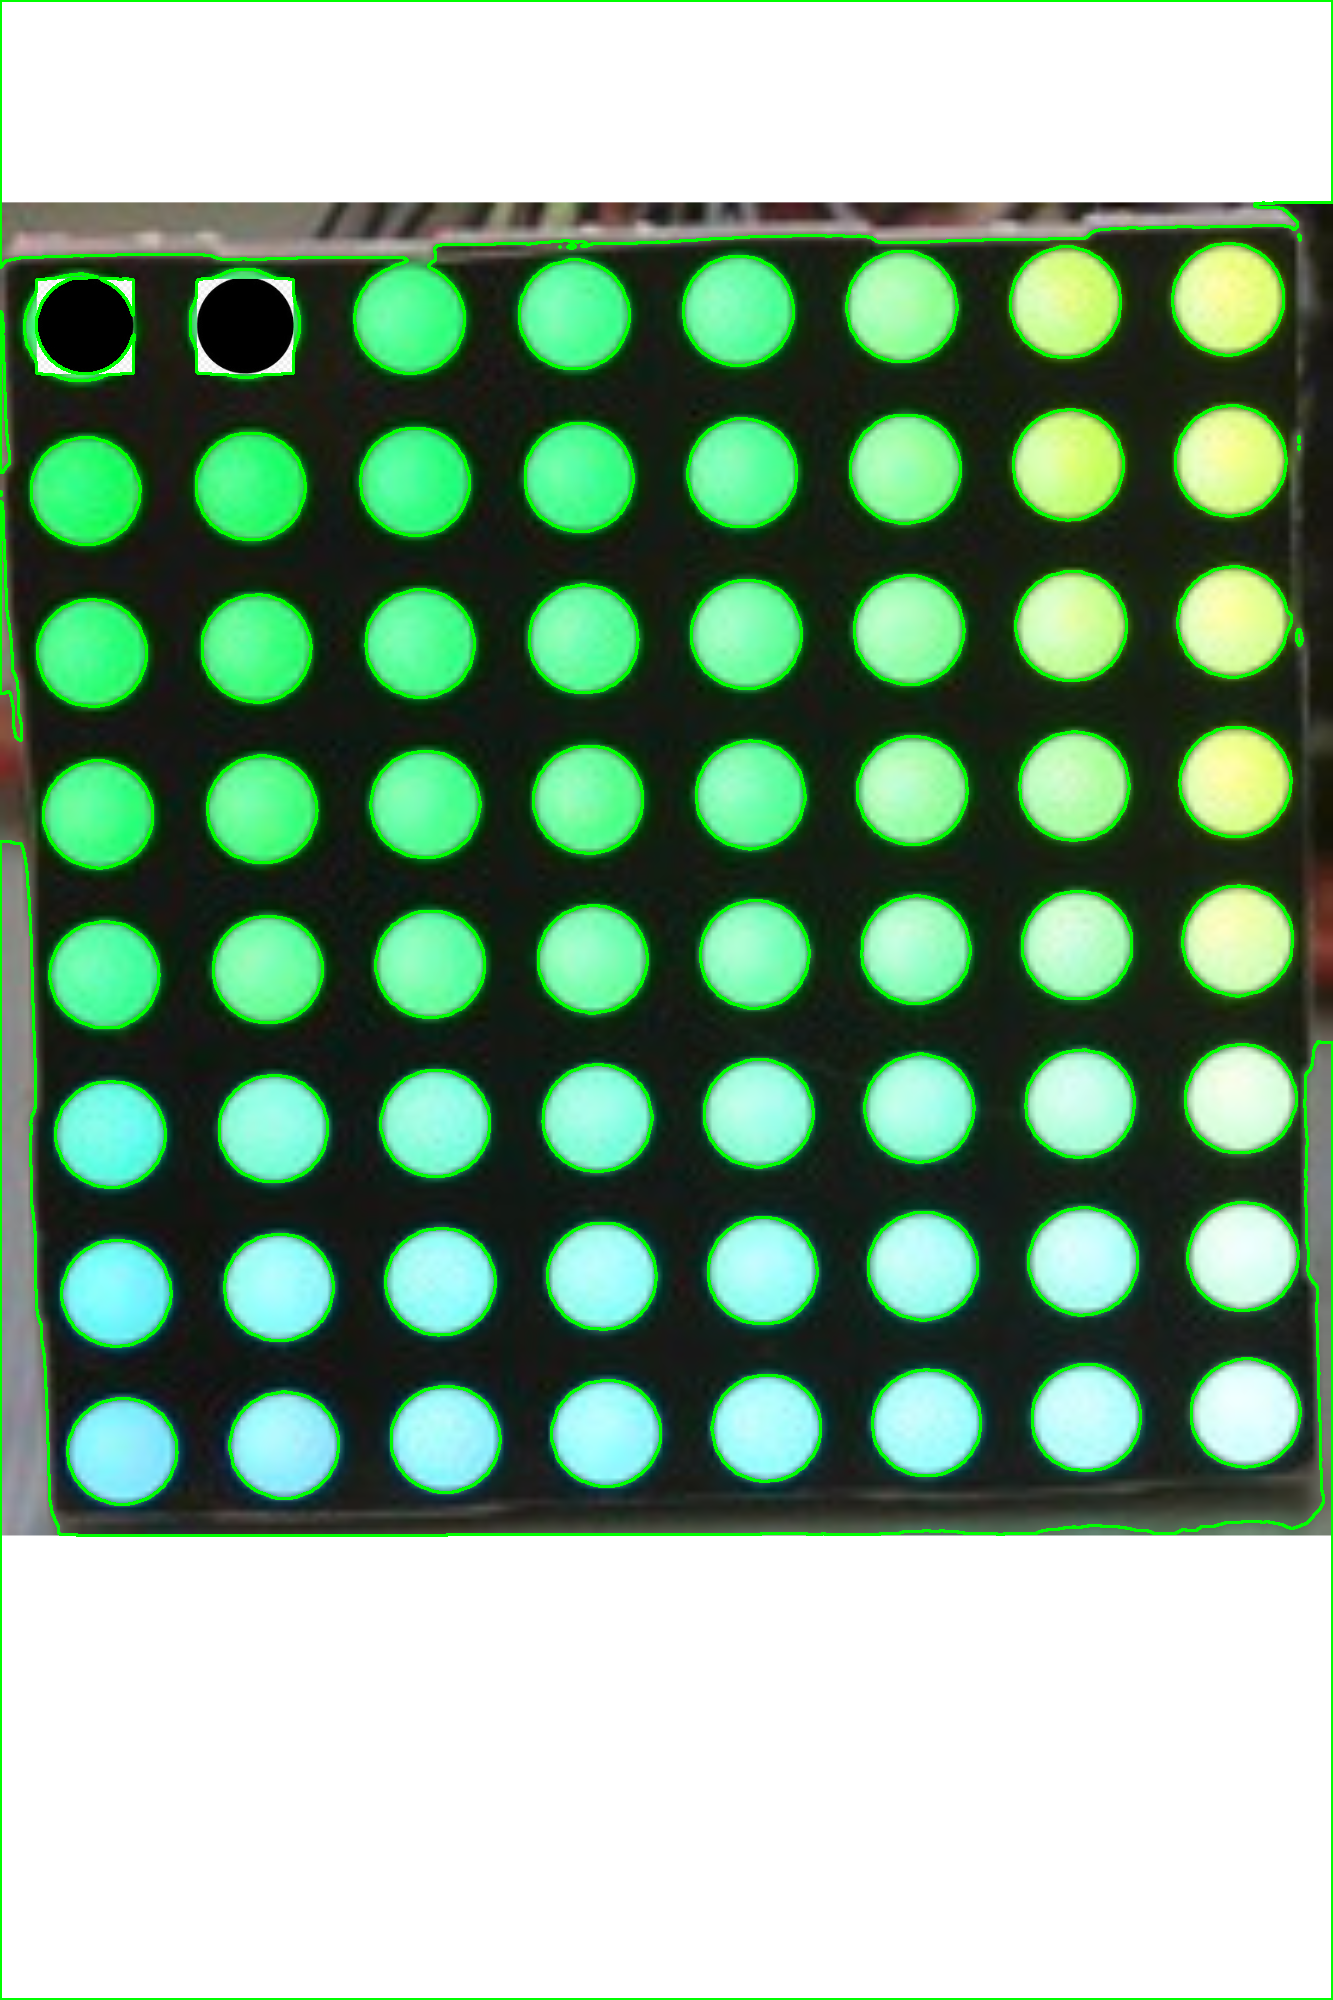

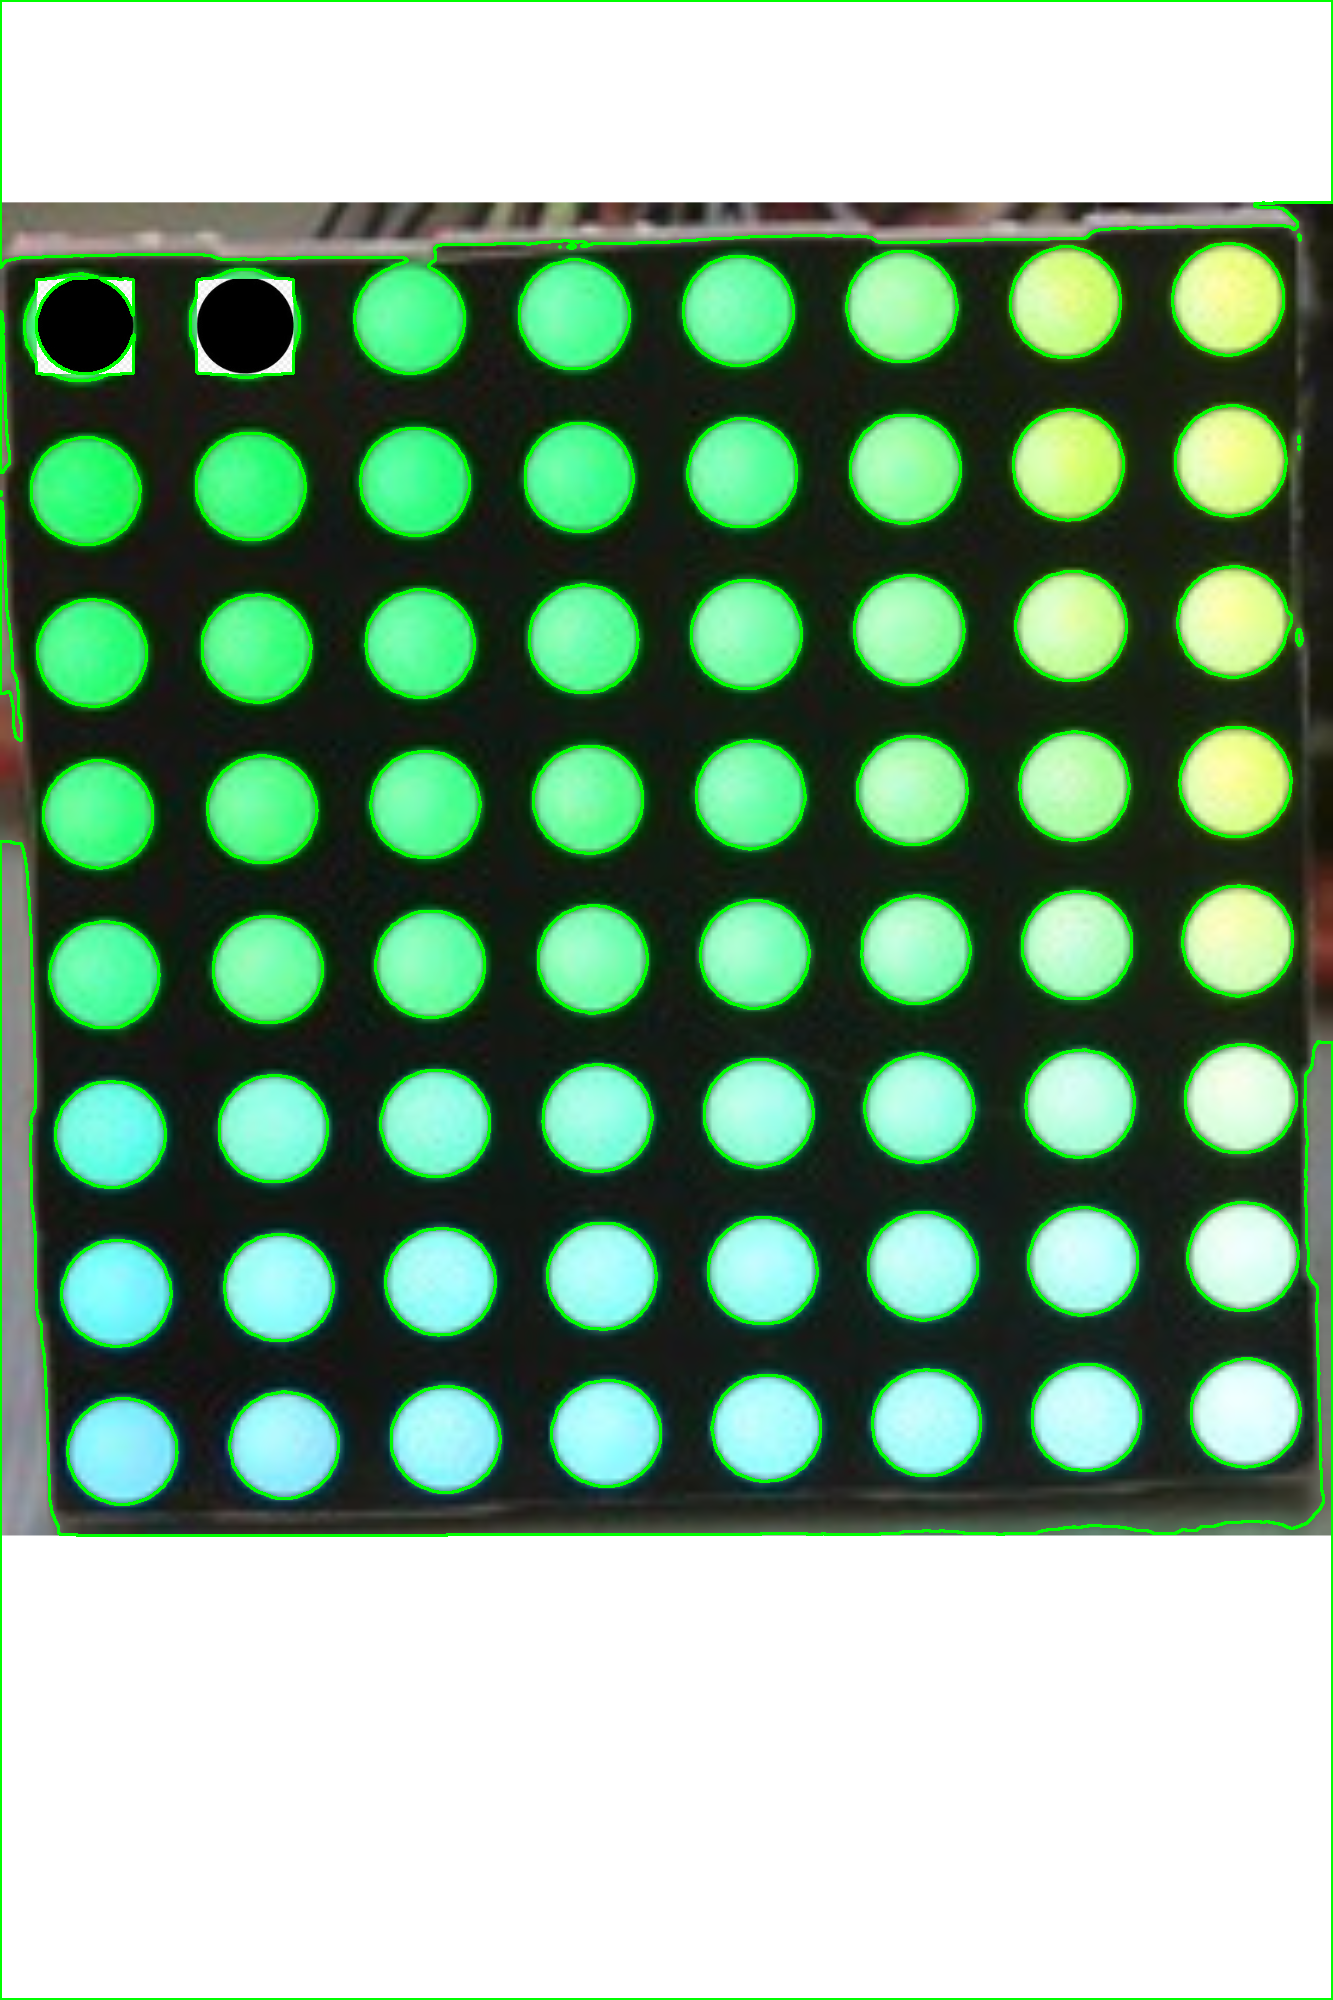

In [ ]:
#SEGMENTATION
import cv2
from google.colab.patches import cv2_imshow
import os

def segment_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform image thresholding (adjust parameters as needed)
    _, thresholded_image = cv2.threshold(blurred_image, 100, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    segmented_image = image.copy()
    cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)

    return segmented_image

def main():
    # Path to the input images
    image_path = '/content/drive/MyDrive/dataset1/left1.png'
    image_path1 = '/content/drive/MyDrive/dataset1/left2.png'

    # Perform image segmentation
    segmented_image = segment_image(image_path)
    segmented_image1 = segment_image(image_path1)

    # Display the segmented images
    cv2_imshow(segmented_image)
    cv2_imshow(segmented_image1)

    # Create a folder to save the segmented images
    output_folder = '/content/drive/MyDrive/output_nvidia'
    os.makedirs(output_folder, exist_ok=True)

    # Save the segmented images
    cv2.imwrite(os.path.join(output_folder, 'segmented_image1.jpg'), segmented_image)
    cv2.imwrite(os.path.join(output_folder, 'segmented_image2.jpg'), segmented_image1)

if __name__ == "__main__":
    main()


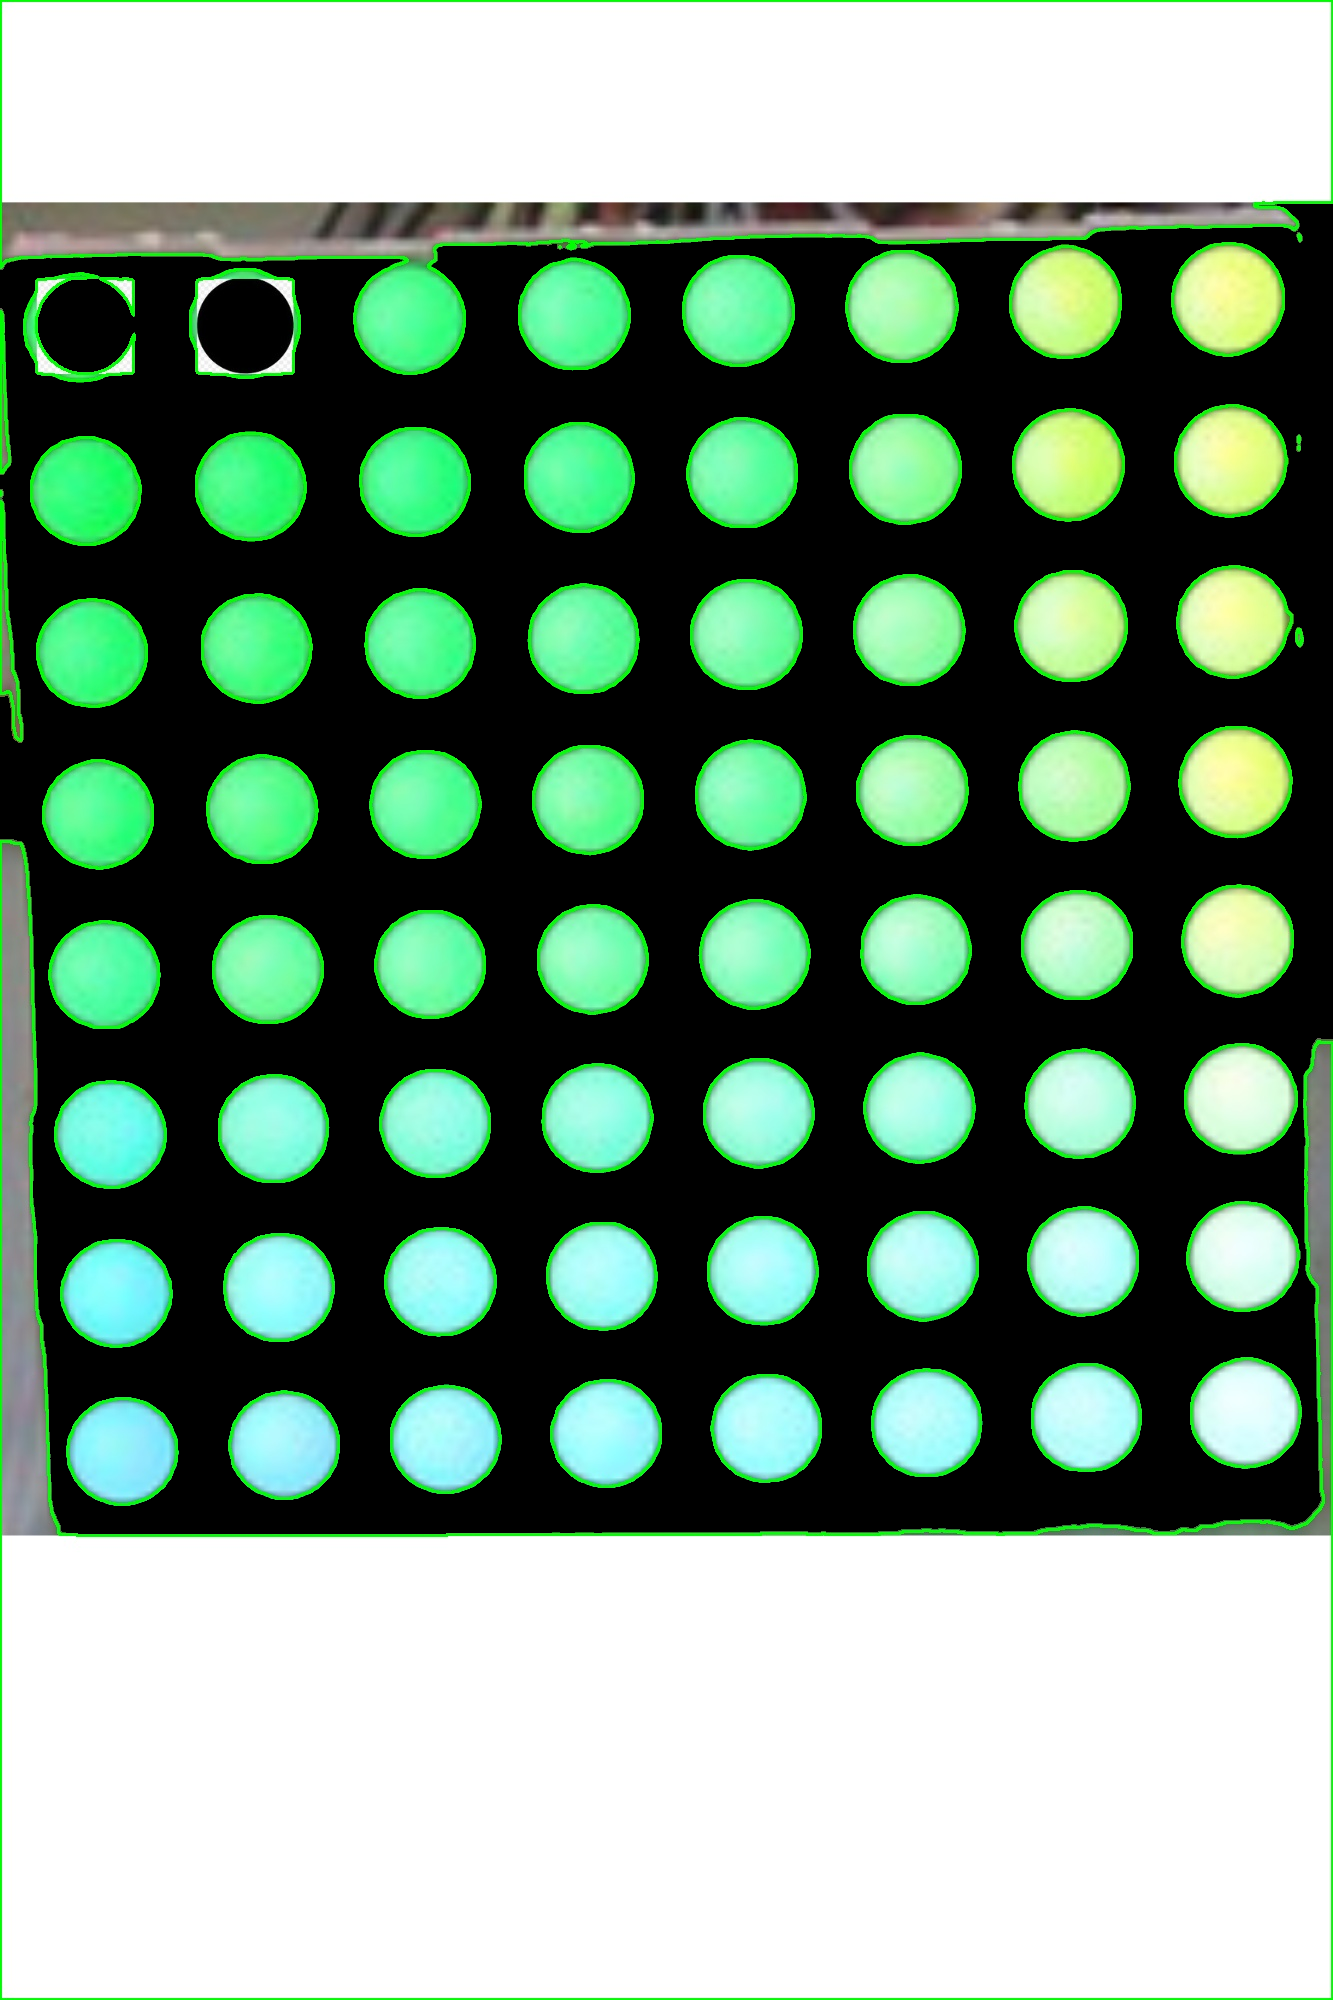

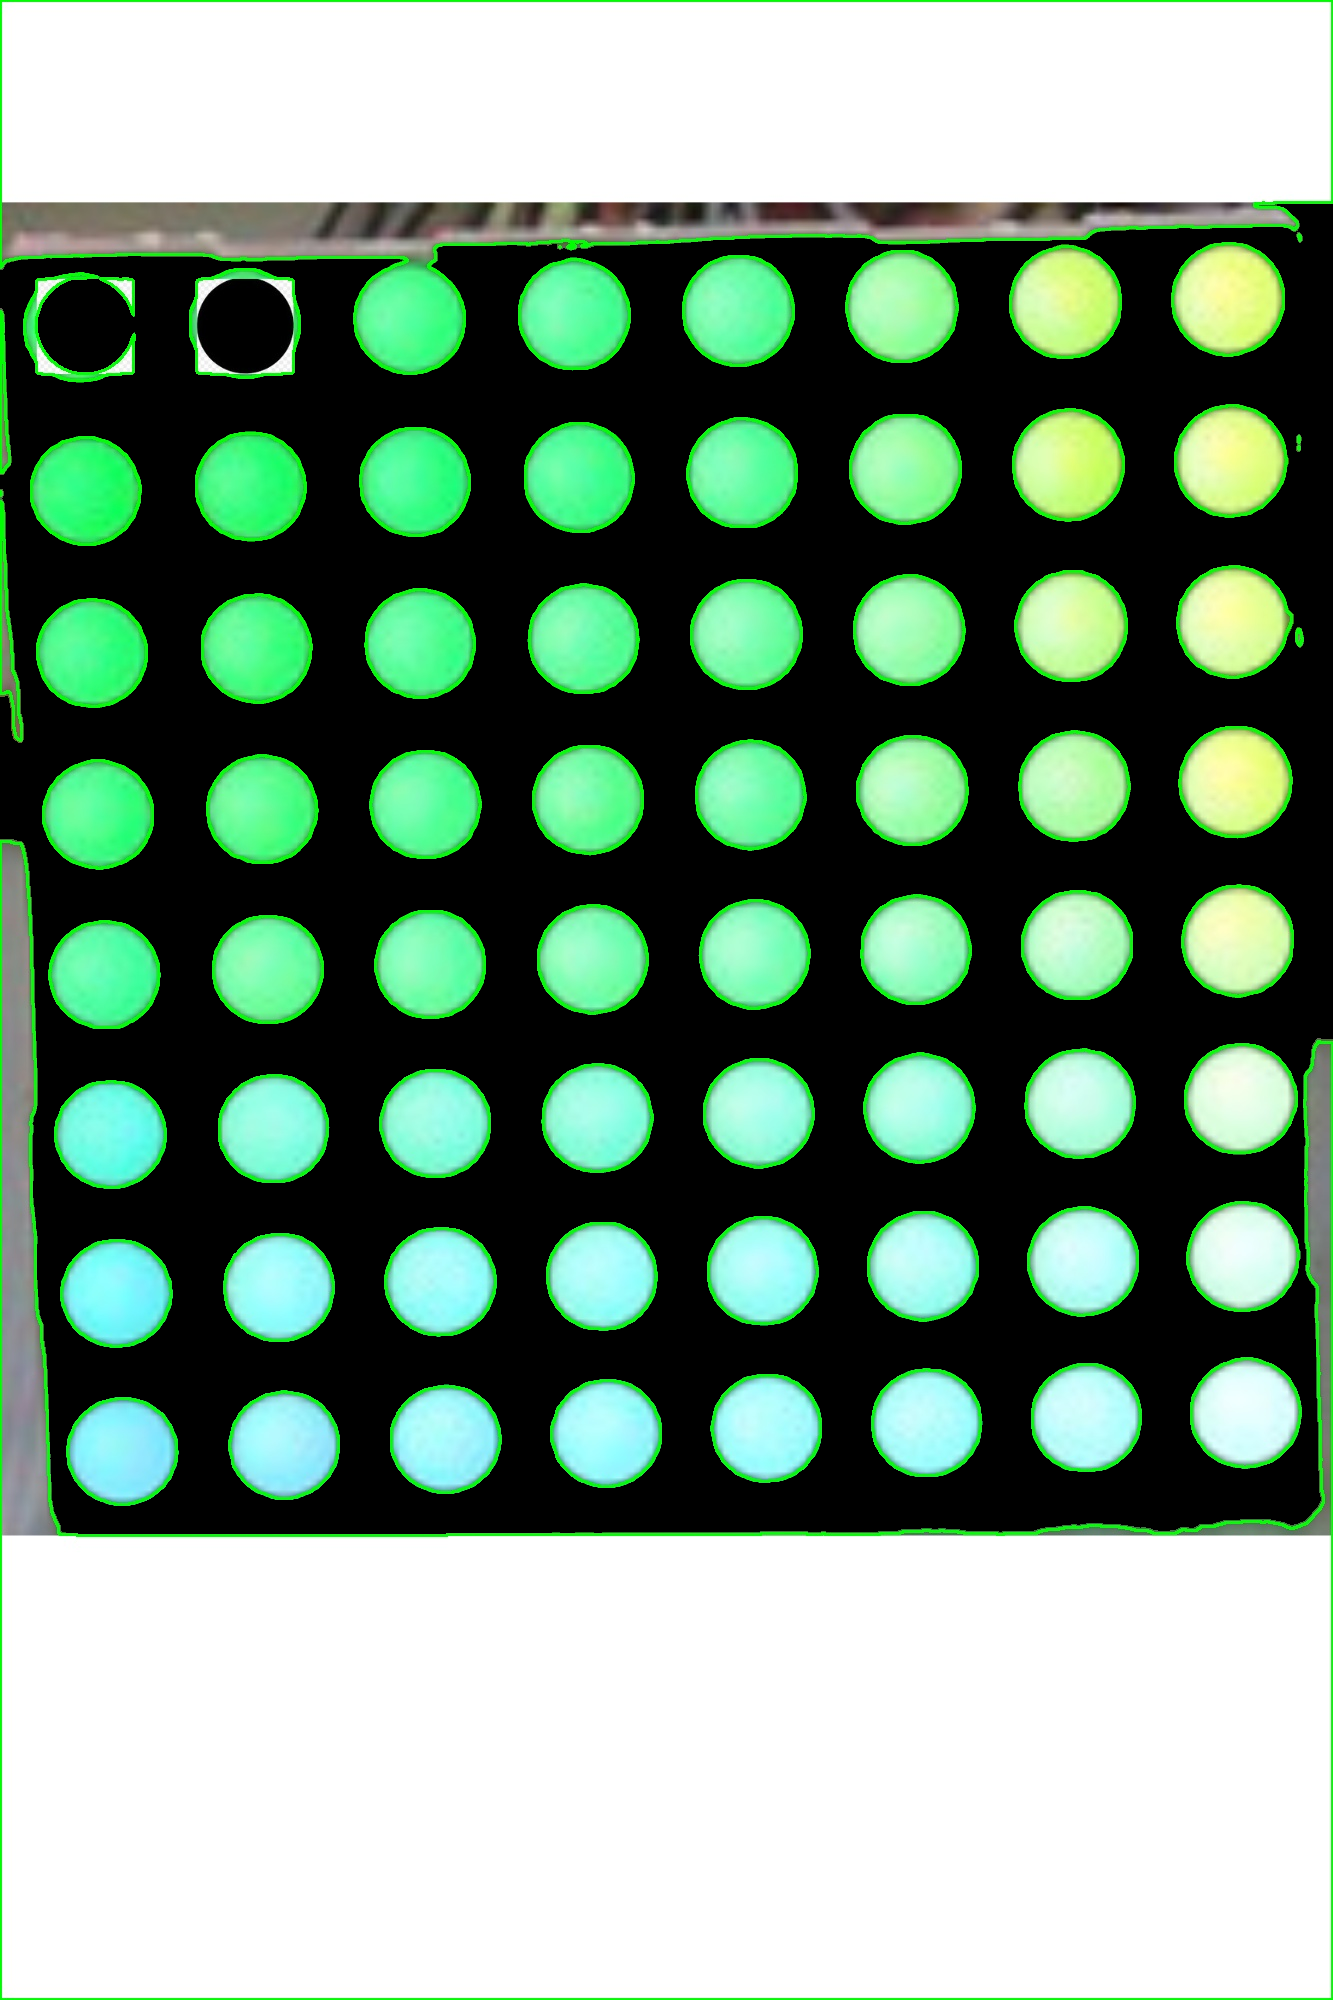

In [ ]:
#REMOVING BACKGROUND
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

def segment_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform image thresholding (adjust parameters as needed)
    _, thresholded_image = cv2.threshold(blurred_image, 100, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to retain only the segmented part
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, contours, -1, (255), cv2.FILLED)

    # Apply the mask to the original image to extract the segmented part
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

def main():
    # Path to the input images
    image_path = '/content/drive/MyDrive/output_nvidia/segmented_image1.jpg'
    image_path1 = '/content/drive/MyDrive/output_nvidia/segmented_image2.jpg'

    # Perform image segmentation
    segmented_image = segment_image(image_path)
    segmented_image1 = segment_image(image_path1)

    # Display the segmented images
    cv2_imshow(segmented_image)
    cv2_imshow(segmented_image1)

    # Create a folder to save the segmented images
    output_folder = '/content/drive/MyDrive/output_nvidia1'
    os.makedirs(output_folder, exist_ok=True)

    # Save the segmented images
    cv2.imwrite(os.path.join(output_folder, 'segmented_image1.jpg'), segmented_image)
    cv2.imwrite(os.path.join(output_folder, 'segmented_image2.jpg'), segmented_image1)

if __name__ == "__main__":
    main()


In [ ]:
#INTENSITY MATRIX OF LEFT IMAGE
import cv2
import numpy as np
import os

def block_matching(image1, image2, block_size=16):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize block matcher
    block_matcher = cv2.BFMatcher_create(cv2.NORM_L2)

    # Divide the images into blocks
    h, w = gray1.shape
    grid_size = (h // block_size, w // block_size)

    # Initialize list to store matched block coordinates
    matched_blocks = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Define block region in the first image
            block1 = gray1[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]

            # Search for the most similar block in the second image
            min_distance = float('inf')
            best_match = None
            for m in range(-1, 2):
                for n in range(-1, 2):
                    row = i * block_size + m
                    col = j * block_size + n
                    if 0 <= row < h - block_size and 0 <= col < w - block_size:
                        block2 = gray2[row:row + block_size, col:col + block_size]
                        distance = np.sum((block1.astype(np.float32) - block2.astype(np.float32)) ** 2)
                        if distance < min_distance:
                            min_distance = distance
                            best_match = (row, col)

            # Add the best match to the list
            if best_match:
                matched_blocks.append(((i * block_size, j * block_size), best_match))

    return matched_blocks

def store_average_intensity(image, matched_blocks, block_size=16, output_folder="output"):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize a list to store average intensity values
    average_intensities = []

    # Iterate through each matched block and calculate average intensity
    for block1, _ in matched_blocks:
        x1, y1 = block1
        # Extract the intensity values from the segmented region
        intensity_values = gray[x1:x1 + block_size, y1:y1 + block_size].flatten()
        # Calculate the average intensity value
        average_intensity = np.mean(intensity_values)
        # Append the average intensity value to the list
        average_intensities.append(average_intensity)

    # Save average intensities as a text file
    with open(os.path.join(output_folder, "average_intensities.txt"), "w") as file:
        for intensity in average_intensities:
            file.write(f"{intensity}\n")

# Read the segmented image
segmented_image = cv2.imread('/content/drive/MyDrive/output_nvidia/segmented_image1.jpg')

# Perform block matching
matched_blocks = block_matching(segmented_image, segmented_image)

# Store average intensities of each segmented region in the output folder
store_average_intensity(segmented_image, matched_blocks, output_folder="/content/drive/MyDrive/output_nvidia1/matics")


In [ ]:
#INTENSITY MATRIX OF RIGHT IMAGE
import cv2
import numpy as np
import os

def block_matching(image1, image2, block_size=16):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize block matcher
    block_matcher = cv2.BFMatcher_create(cv2.NORM_L2)

    # Divide the images into blocks
    h, w = gray1.shape
    grid_size = (h // block_size, w // block_size)

    # Initialize list to store matched block coordinates
    matched_blocks = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Define block region in the first image
            block1 = gray1[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]

            # Search for the most similar block in the second image
            min_distance = float('inf')
            best_match = None
            for m in range(-1, 2):
                for n in range(-1, 2):
                    row = i * block_size + m
                    col = j * block_size + n
                    if 0 <= row < h - block_size and 0 <= col < w - block_size:
                        block2 = gray2[row:row + block_size, col:col + block_size]
                        distance = np.sum((block1.astype(np.float32) - block2.astype(np.float32)) ** 2)
                        if distance < min_distance:
                            min_distance = distance
                            best_match = (row, col)

            # Add the best match to the list
            if best_match:
                matched_blocks.append(((i * block_size, j * block_size), best_match))

    return matched_blocks

def store_average_intensity(image, matched_blocks, block_size=16, output_folder="output"):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize a list to store average intensity values
    average_intensities = []

    # Iterate through each matched block and calculate average intensity
    for block1, _ in matched_blocks:
        x1, y1 = block1
        # Extract the intensity values from the segmented region
        intensity_values = gray[x1:x1 + block_size, y1:y1 + block_size].flatten()
        # Calculate the average intensity value
        average_intensity = np.mean(intensity_values)
        # Append the average intensity value to the list
        average_intensities.append(average_intensity)

    # Save average intensities as a text file
    with open(os.path.join(output_folder, "average_intensities.txt"), "w") as file:
        for intensity in average_intensities:
            file.write(f"{intensity}\n")

# Read the segmented image
segmented_image = cv2.imread('/content/drive/MyDrive/output_nvidia1/segmented_image2.jpg')

# Perform block matching
matched_blocks = block_matching(segmented_image, segmented_image)

# Store average intensities of each segmented region in the output folder
store_average_intensity(segmented_image, matched_blocks, output_folder="/content/drive/MyDrive/output_nvidia1/matics1")


In [ ]:
#COMPARING BOTH INTENSITY MATRICES
import os
import numpy as np

def compare_intensity_matrices(matrix1_path, matrix2_path):
    # List all text files in the directories
    matrix1_files = [f for f in os.listdir(matrix1_path) if f.endswith('.txt')]
    matrix2_files = [f for f in os.listdir(matrix2_path) if f.endswith('.txt')]

    # Sort the file lists to ensure consistent order
    matrix1_files.sort()
    matrix2_files.sort()

    # Compare each pair of intensity matrices
    if len(matrix1_files) != len(matrix2_files):
        return "async"

    for file1, file2 in zip(matrix1_files, matrix2_files):
        matrix1 = np.loadtxt(os.path.join(matrix1_path, file1))
        matrix2 = np.loadtxt(os.path.join(matrix2_path, file2))
        if not np.array_equal(matrix1, matrix2):
            return "async"

    return "sync"

# Provide paths to two directories containing intensity matrix files
matrix1_path = '/content/drive/MyDrive/output_nvidia1/matics'
matrix2_path = '/content/drive/MyDrive/output_nvidia1/matics1'

# Compare the intensity matrices
result = compare_intensity_matrices(matrix1_path, matrix2_path)

# Print the result
print(result)


sync
